In [1]:
#TIVE QUE INSTALAR UMA BIBLIOTECA QUE FALTOU...

!pip install missingno

In [4]:
#IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS

import warnings 
warnings.filterwarnings('ignore')

# Bibliotecas Básicas
import os
import pandas as pd
import numpy as np
from PIL import Image


# Plotagem e Visualização
import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import missingno as msno

# Pre-Processamento
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)
# Modelando
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler


from tensorflow.keras import backend as K
K.clear_session()

# Plotagem do Modelo
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

# Mesclagem
from sklearn.utils import shuffle

In [37]:
#DEFININDO E CONFERINDO O TAMANHO DE CADA DATASET

train_dir = "C:/Users/Will/Documents/Data_Science/Projeto Final/dogs-vs-cats/train/"
test_dir  = "C:/Users/Will/Documents/Data_Science/Projeto Final/dogs-vs-cats/test1/"
print("Total de imagens no dataset de treino e teste...")
print('\n' + 'No. de imagens de treino: '+ str(len(os.listdir(train_dir))))
print('No. de imagens de testes: ' + str(len(os.listdir(test_dir))) + '\n')

Total de imagens no dataset de treino e teste...

No. de imagens de treino: 25000
No. de imagens de testes: 12500



In [51]:
# ARMAZENANDO AS IMAGENS EM DATAFRAMES

def category(path): 
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

x_train_imgname = filename(train_dir) 
x_test_imgname = filename(test_dir)
y_train_label = category(train_dir)

train_image_df = pd.DataFrame({ 'filename': x_train_imgname, 'category': y_train_label})
submission_image_df = pd.DataFrame({'filename': x_test_imgname})

print(train_image_df.head())

       filename category
0     cat.0.jpg      cat
1     cat.1.jpg      cat
2    cat.10.jpg      cat
3   cat.100.jpg      cat
4  cat.1000.jpg      cat


In [53]:
#FUNÇÕES AUXILIARES

def img_path(directory):
    ''' 
    Esta função extrai os IDs das imagens, categoria e caminho do diretório.
    Input:
    directiory: Local das imagens
    Return:
    ID_no: Lista dos IDs das imagens
    Paths: Lista do caminho das imagens
    cate: Lista das categorias
    '''
    paths = []
    cate = []
    ID_no = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        paths.append(path)
        cate.append(file.split('.')[0])
        ID_no.append(file.split('.')[1])
    return ID_no, paths, cate




def showImages(data,num_row  = 3,num_col =  3, name = 'any', subtitle = 'off'):
    """ Esta função cria uma grade de imagens do conjunto de dados.
    Imagens embaralhadas serão exibidas.
    
    Input: 
    num_row: default: 3, numero de linhas em uma grade
    num_col: default:3, numero de colunas em uma grade
    data: Dataframe de caminhos 
    name:  padrão 'qualquer', leva: gato, cachorro, qualquer outra coisa daria ambos
    subtitle: exibe o número de identificação de cada imagem, padrão: 'off', leva: 'on' e 'off'
    Return: None
    
    """
    
    # Pequena classificação de dados
    cat_df,dog_df = data[data['Category'] == 'cat'], data[data['Category'] == 'dog']

    
    if name == 'dog':
        X, Y  = dog_df['img_paths'], dog_df['ID_no']
    elif name == 'cat':
        X, Y  = cat_df['img_paths'], cat_df['ID_no']     
    else:
        X, Y  = data['img_paths'], data['ID_no']     # poderia usar try e except, mas vamos nos ater ao código mínimo

    (X_rand, Y_rand) = shuffle(X, Y)
    
    # mostrando as imagens com matplotlib 
    
    fig, ax = plt.subplots(num_row,num_col,figsize = (12,12), dpi = 100)
    fig.patch.set_facecolor('#f5f6f6')
    axes = ax.ravel()
    
    for idx,ax  in enumerate(axes):
        x = load_img(X_rand.iloc[idx],target_size= (125, 125))
        ax.imshow(x)
        if subtitle == 'on':
            ax.set_title("{}".format(Y_rand.iloc[idx]))
        else:
            ax.set_title('')
        ax.axis('off')
        plt.subplots_adjust(wspace =0)
        del x
    #fig.tight_layout()
    
    fig.text(0.1,0.93, '{}s da base de treinamento'.format(name.capitalize()),{'fontfamily':'serif','size':18,'weight':'bold'})
    
    return None

NameError: name 'cat_df' is not defined

In [42]:
# Implementando a função acima sobre o conjunto de dados de testes
ID_no, img_paths, train_images = img_path(train_dir)

print('\n' + 'Dataframe está sendo criado para visualização de imagens de treinamento em uma grade...' + '\n' )
#creando novo dataframe para visualização de dados

visual_df = pd.DataFrame({'ID_no':ID_no,'Category':train_images, 'img_paths': img_paths})

print(visual_df.head(5))

print('\n' + 'Feito!' + '\n')


Dataframe está sendo criado para visualização de imagens de treinamento em uma grade...

  ID_no Category                                          img_paths
0     0      cat  C:/Users/Will/Documents/Data_Science/Projeto F...
1     1      cat  C:/Users/Will/Documents/Data_Science/Projeto F...
2    10      cat  C:/Users/Will/Documents/Data_Science/Projeto F...
3   100      cat  C:/Users/Will/Documents/Data_Science/Projeto F...
4  1000      cat  C:/Users/Will/Documents/Data_Science/Projeto F...

Feito!



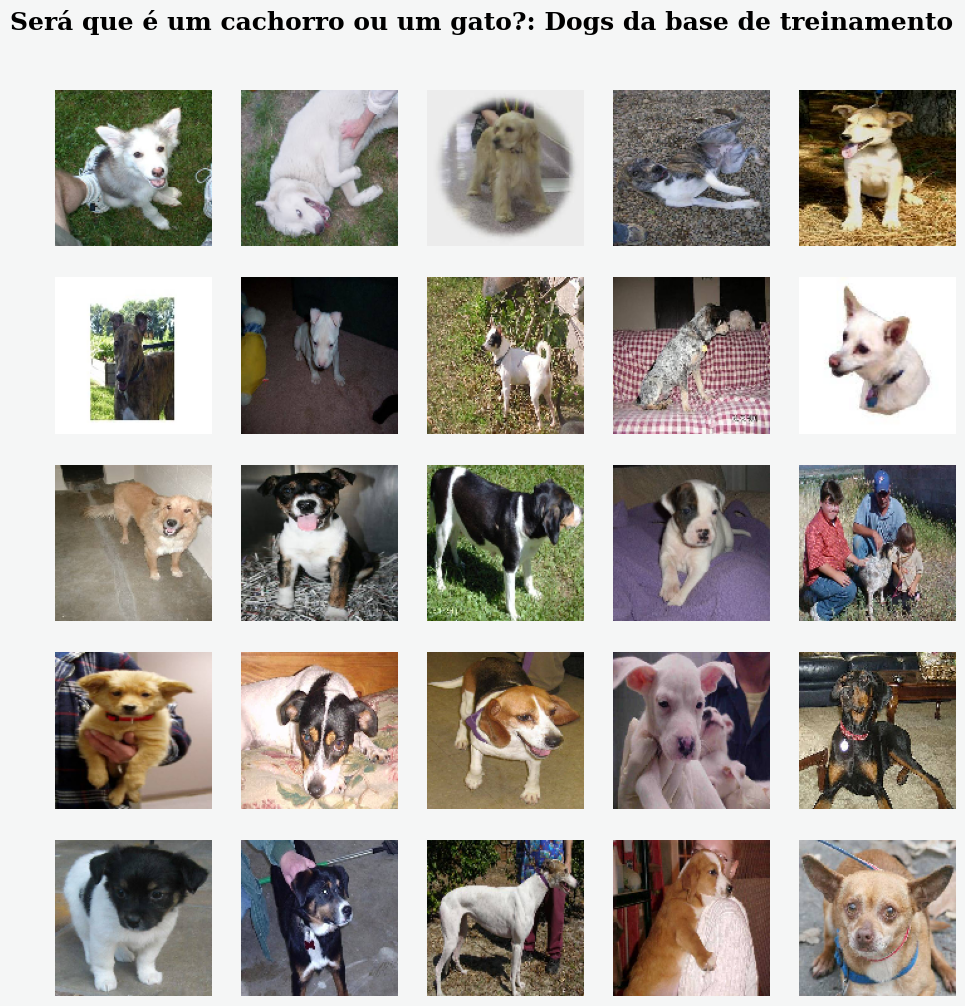

In [43]:
#VISUALIZANDO ALGUNS CÃES DO DATASET DE TREINAMENTO

showImages(visual_df,5,5, name = 'dog', subtitle = 'off')

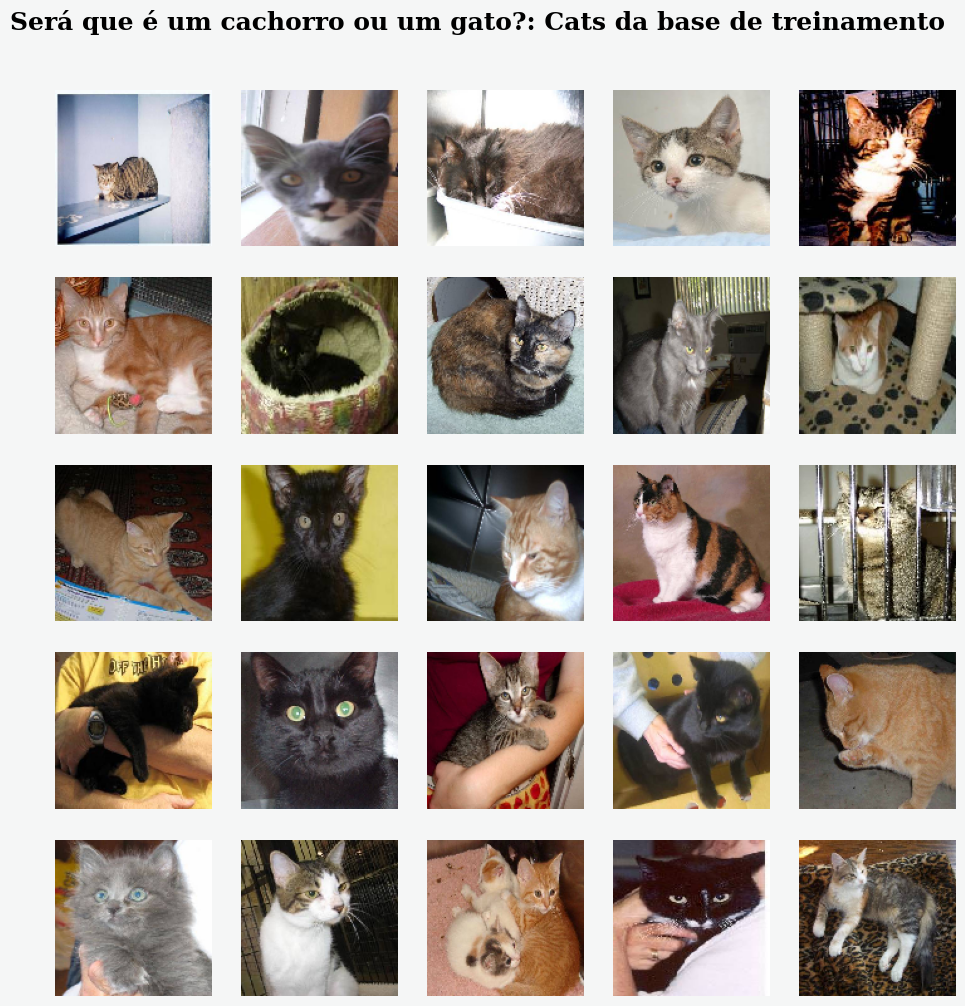

In [10]:
#VISUALIZANDO ALGUNS GATOS DO DATASET DE TREINAMENTO

showImages(visual_df,5,5, name = 'cat', subtitle = 'off')

In [44]:
# DIVIDINDO OS DADOS ENTRE UMA BASE DE TREINAMENTO E TESTES
train_valid_df, test_df = train_test_split(train_image_df, test_size = 0.04)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
holdon_images = test_df.shape[0]
test_images = submission_image_df.shape[0]

print('\n' + 'Numero de imagens de treinamento: ' + str(train_images))
print('\n' +  'Numero de imagens de validação: ' + str(valid_images))
print('\n' +  'Numero de imagens de espera: ' + str(holdon_images))
print('\n' + 'Numero de imagens de testes: ' +str(test_images))


Numero de imagens de treinamento: 19200

Numero de imagens de validação: 4800

Numero de imagens de espera: 1000

Numero de imagens de testes: 12500


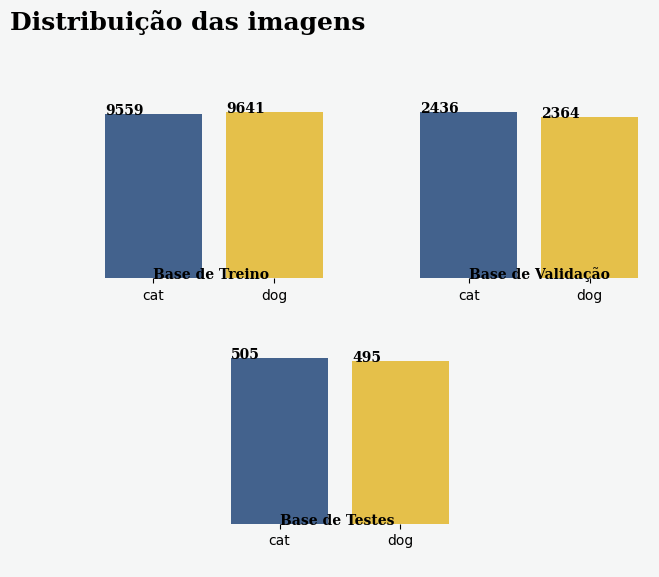

In [12]:
#ANALISANDO A DISTRIBUIÇÃO DAS IMAGENS

fig = plt.figure(figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')
gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[2:5,1:5])
ax1 = fig.add_subplot(gs[2:5,6:10])
ax2 = fig.add_subplot(gs[6:9,3:7])


axes = [ax0,ax1,ax2]
data  = [train_df['category'] ,  valid_df['category'], test_df['category']]
labels = ['Base de Treino','Base de Validação','Base de Testes']

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.axes.get_yaxis().set_visible(False)
    
    for loc in ['left','right','top','bottom']:
        ax.spines[loc].set_visible(False)
    
for ax,df, label in zip(axes,data,labels):
    sns.countplot(df, ax = ax, palette = ['#36609A','#FFCE30'], alpha =1)
    ax.set_xlabel(xlabel = ' ')
    for pa in ax.patches: 
        ax.text(pa.get_x(), pa.get_height(),'{}'.format(pa.get_height()), **{'fontfamily':'serif', 'size':10, 'weight':'bold'}, alpha = 1)

    ax.text(0,0,label,**{'fontfamily':'serif', 'size':10, 'weight':'bold'})

fig.text(0.1,0.82, 'Distribuição das imagens',{'fontfamily':'serif','size':18,'weight':'bold'})
fig.show()

In [13]:
#CLASSIFICAÇÃO UTILIZANDO VANILA CNN

img_size = 224
batch_size = 128

# iteradores de dataframe sem adição de dados

train_map = ImageDataGenerator()
valid_map = ImageDataGenerator()
test_map =  ImageDataGenerator()
        
#Criando iteradores de dataframe para ajuste
vani_train_data = train_map.flow_from_dataframe(
            train_df,train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

vani_valid_data = valid_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


vani_test_data = test_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = None,
             shuffle = False)

Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [14]:
#CONSTRUINDO O MODELO

vani_model = Sequential()
vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,3)))
vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Flatten())

vani_model.add(Dense(512, activation = 'relu'))

vani_model.add(Dropout(0.5))

vani_model.add(Dense(2, activation = 'softmax')) # 2 PORQUE NÓS TEMOS AS CLASSES DE CACHORRO E GATO

vani_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        1

In [15]:
#TREINANDO O MODELO

#compilando modelo com loss, opt, metricas
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']

vani_model.compile(loss = loss, optimizer = opt, metrics = metrics)

# ajustar (fitting) o modelo para o conjunto de dados de treinamento
vani_history = vani_model.fit(vani_train_data, epochs = 10,
                          validation_data = vani_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

Epoch 1/10
150/150 [==============================] - 6299s 42s/step - loss: 0.8711 - accuracy: 0.5518 - val_loss: 0.6645 - val_accuracy: 0.5762
Epoch 2/10
150/150 [==============================] - 6311s 42s/step - loss: 0.6130 - accuracy: 0.6628 - val_loss: 0.5940 - val_accuracy: 0.6826
Epoch 3/10
150/150 [==============================] - 6201s 41s/step - loss: 0.5468 - accuracy: 0.7236 - val_loss: 0.5630 - val_accuracy: 0.6856
Epoch 4/10
150/150 [==============================] - 6193s 41s/step - loss: 0.4981 - accuracy: 0.7574 - val_loss: 0.4939 - val_accuracy: 0.7565
Epoch 5/10
150/150 [==============================] - 6184s 41s/step - loss: 0.4534 - accuracy: 0.7869 - val_loss: 0.4204 - val_accuracy: 0.8022
Epoch 6/10
150/150 [==============================] - 6188s 41s/step - loss: 0.4197 - accuracy: 0.8095 - val_loss: 0.4344 - val_accuracy: 0.7977
Epoch 7/10
150/150 [==============================] - 6193s 41s/step - loss: 0.3814 - accuracy: 0.8277 - val_loss: 0.3957 - val_ac

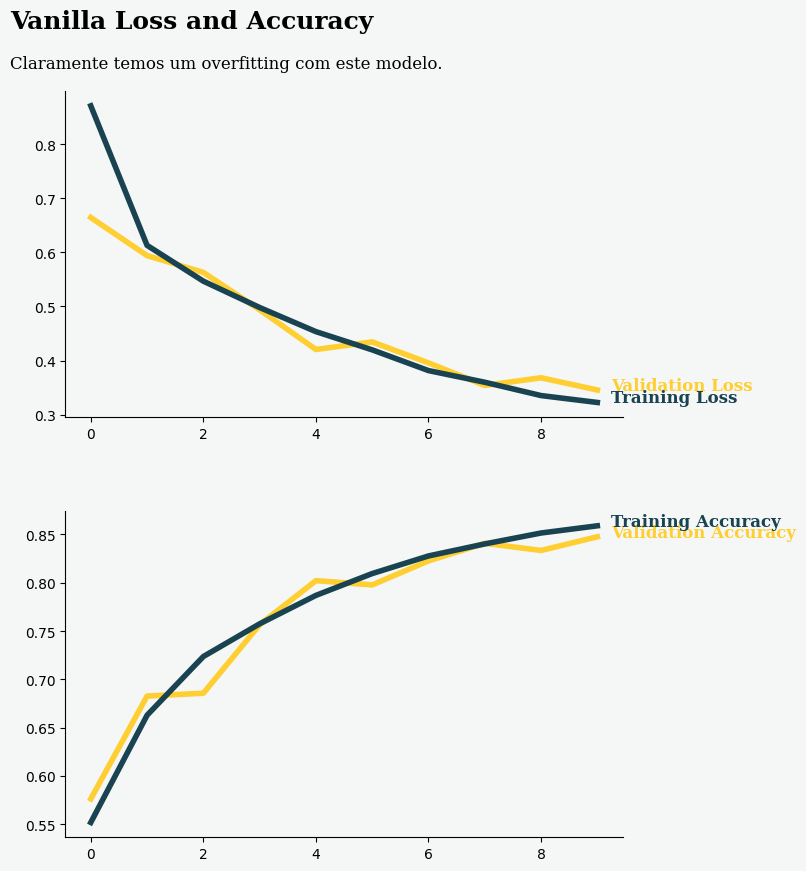

In [16]:
#Vamos representar graficamente a mudança do modelo Vanila CNN na perda e precisão com as épocas

# paleta de cores
colors = ['#EF7D71','#41ABD7','#36609A','#FFCE30','#194350']

fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist1 = vani_history.history
Epochs =  range(len(hist1['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist1['val_loss'],  ax = axes[0], linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist1['loss'], ax  = axes[0], linewidth =4,  color = colors[4])


axes[0].text(Epochs[-1]+0.25,hist1['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[0].text(Epochs[-1]+0.25,hist1['loss'][-1] ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


# accuracy plot
sns.lineplot(x = Epochs, y = hist1['val_accuracy'],ax = axes[1],linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist1['accuracy'],ax = axes[1],linewidth =4,  color = colors[4])
axes[1].text(Epochs[-1]+0.25,hist1['val_accuracy'][-1],'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[1].text(Epochs[-1]+0.25,hist1['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


fig.text(0,1.06, 'Vanilla Loss and Accuracy ',{'fontfamily':'serif', 'size':18, 'weight':'bold'})
fig.text(0,1.01, '''Claramente temos um overfitting com este modelo.''',{'fontfamily':'serif', 'size':12})

plt.tight_layout(h_pad = 5)

In [46]:
#APLICANDO A CONFUSION MATRIX NO MODELO CNN VANILLA

vani_pred = vani_model.predict_generator(vani_test_data)
test_df['vani_pred'] = np.argmax(vani_pred, axis = -1)
labels = dict((v,k) for k,v in vani_train_data.class_indices.items())

test_df['vani_pred'] = test_df['vani_pred'].map(labels)

In [47]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # CÓDIGO PARA GERAR TEXTO DENTRO DE CADA QUADRADO
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CÓDIGO PARA GERAR ESTATÍSTICAS RESUMIDAS E TEXTO PARA ESTATÍSTICAS RESUMIDAS
    if sum_stats:
        #A precisão é a soma da diagonal dividida pelo total de observações
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #se for uma matriz de confusão binária, mostre mais algumas estatísticas
        if len(cf)==2:
            #Métricas para matrizes de confusão binárias
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # AJUSTE OS PARÂMETROS DA FIGURA DE ACORDO COM OUTROS ARGUMENTOS
    if figsize==None:
        #Obtenha o tamanho padrão da figura se não for definido
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Não mostrar categorias se xyticks for False
        categories=False


    # FAÇA A VISUALIZAÇÃO DO HEATMAP
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf,annot=box_labels,fmt="",linewidths = 1,square = True,linecolor= '#f5f6f6',
                cmap=cmap,cbar=cbar,annot_kws={'fontfamily':'serif','size':18,'weight':'bold'},
                xticklabels=categories,
                yticklabels=categories,)

    if xyplotlabels:
        plt.ylabel('True label', **{'fontfamily':'serif','size':12,'weight':'bold'})
        plt.xlabel('Predicted label' + stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    else:
        plt.xlabel(stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    
    plt.gca().set_xticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})
    plt.gca().set_yticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})

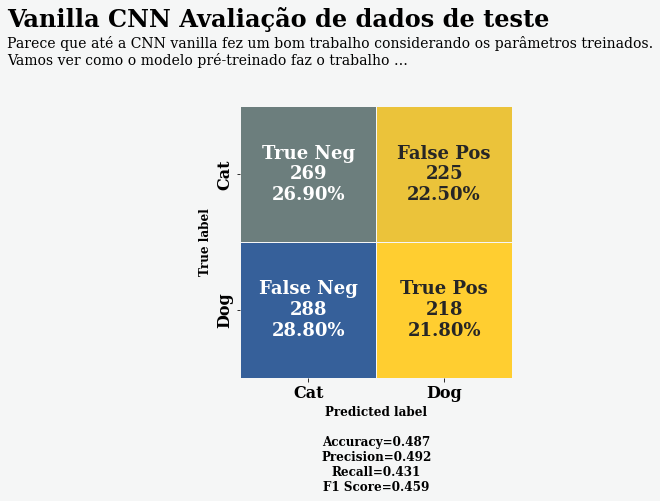

In [48]:
vani_cf_matrix = confusion_matrix(test_df['category'],test_df['vani_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(vani_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories, 
                      title = 'Vanila CNN matriz de confusão')

plt.gcf().text(0,1.1,'Vanilla CNN Avaliação dos dados de teste',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.995,"""Parece que até a CNN vanilla fez um bom trabalho considerando os parâmetros treinados.
Vamos ver como o modelo pré-treinado faz o trabalho ...""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().show()

In [20]:
#Vamos codificar a função auxiliar para visualização do aumento da imagem ...

def data_argumentation_show(n, grid_size):
    sample_aug_map = ImageDataGenerator(
            #zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            rescale = 1/255)
    sample_data = sample_aug_map.flow_from_dataframe(
            (train_df.sample(n)),
            train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()
     
    return None

Found 1 validated image filenames belonging to 1 classes.


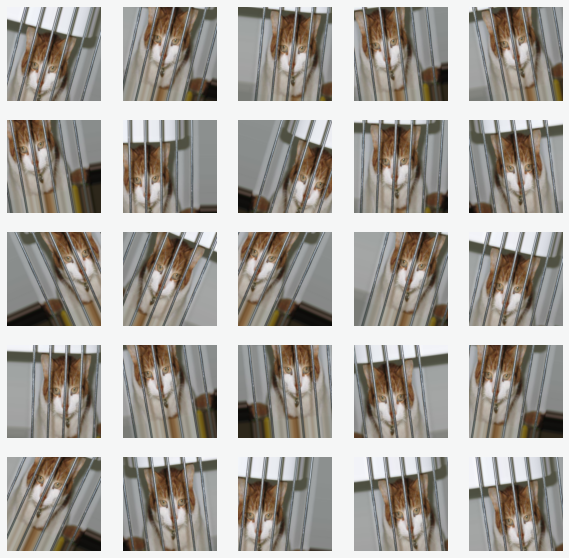

In [21]:
# Visulalizar o efeito da argumentação de dados
# selecionar o número de amostras para o argumento----> n = 
# número total de argumentação é grid_Size**2

data_argumentation_show(1, 5)

In [23]:
#Função de definição da taxa de aprendizagem decadente ...

print('\nDefinindo uma taxa de aprendizagem para a programação da taxa de aprendizagem\n')
epoch = 50
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr


Setting a decay learning rate for learning rate schedule



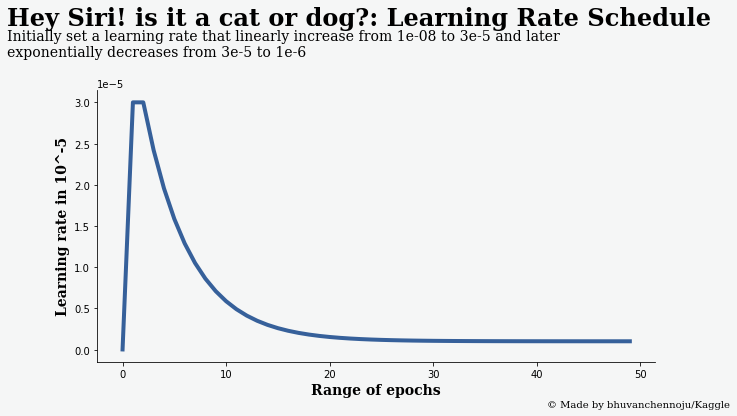

In [24]:
epochs = 20
epochs_range = [i for i in range(50 if epochs<50 else epochs)]
learn_rate = [lrfn(x) for x in epochs_range]


fig,ax = plt.subplots(figsize = (10,5))
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')

for loc in ['right','top',]:
    ax.spines[loc].set_visible(False)

ax.plot(epochs_range, learn_rate, linewidth = 4, color= colors[2]) 
plt.xlabel('Range of epochs',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})
plt.ylabel('Learning rate in 10^-5',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})


plt.gcf().text(0,1.06,'Learning Rate Schedule',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.975,"""Definido inicialmente uma taxa de aprendizagem que aumenta linearmente de 1e-08 para 3e-5 e mais tarde
diminui exponencialmente de 3e-5 para 1e-6""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().show()

In [25]:
# CLASSIFICAÇÃO COM ResNet50

# Preparação de dados para aumento de imagem com ImageDataGenerator

# usando aumento de dados padrão

train_aug_map = ImageDataGenerator(
                    rotation_range=10,
                    #zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #width_shift_range=0.1,
                    #height_shift_range=0.1,
                    preprocessing_function = preprocess_input)
res_train_data = train_aug_map.flow_from_dataframe(
            train_df, train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

valid_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_valid_data = valid_aug_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')

#Dados de testes, reescalonamento de imagens

test_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_test_data = test_aug_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)

Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [26]:
#Construindo um modelo para transferência de aprendizagem em cima de um modelo ResNet50 pré-treinado...

resNet = tf.keras.applications.ResNet50(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224,224, 3))

resNet.trainable = False # Camadas congeladas
resNet_model = Sequential([
        resNet,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.4),
        Dense(2, activation = 'softmax')])
     
optimizer = optimizers.Adam(1e-5)

resNet_model.summary()
#plot_model(resNet_model, to_file='resNet_model.png')

94773248/94765736 [==============================] - 25s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 126,351,234
Trainable params: 102,763,522
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
#Definindo o fator de parada antecipada e a programação da taxa de aprendizagem

earlystop = EarlyStopping(patience= 5)
    
lr_callback = LearningRateScheduler(lrfn, verbose = True)

callbacks = [earlystop, lr_callback]

In [29]:
#Vamos treinar e validar o modelo ResNet50 pré-treinado para as camadas superiores 

resNet_model.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

resnet_history = resNet_model.fit_generator(res_train_data, epochs = 10,
                          validation_data = res_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)


Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
150/150 [==============================] - 9805s 65s/step - loss: 1.7611 - accuracy: 0.5264 - val_loss: 1.3010 - val_accuracy: 0.5477
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 3e-05.
150/150 [==============================] - 9804s 65s/step - loss: 0.2121 - accuracy: 0.9703 - val_loss: 0.0806 - val_accuracy: 0.9865
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 3e-05.
150/150 [==============================] - 9797s 65s/step - loss: 0.0532 - accuracy: 0.9878 - val_loss: 0.0571 - val_accuracy: 0.9863
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 2.4200000000000002e-05.
150/150 [==============================] - 9779s 65s/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.0541 - val_accuracy: 0.9865
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 1.9560000000000006e-05.
150/150 [=====================

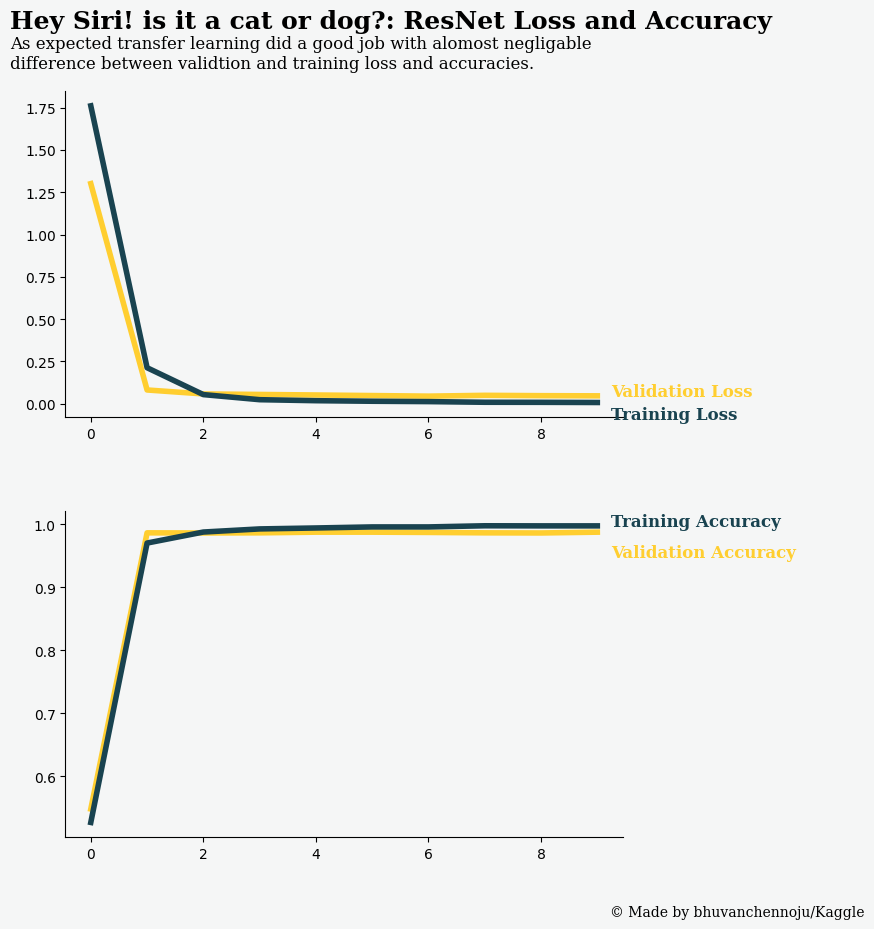

In [30]:
#Plotando o resultado do modelo ResNet

fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist2 = resnet_history.history
Epochs =  range(len(hist2['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist2['val_loss'],  ax = axes[0], linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist2['loss'], ax  = axes[0], linewidth =4,  color = colors[4])


axes[0].text(Epochs[-1]+0.25,hist2['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[0].text(Epochs[-1]+0.25,hist2['loss'][-1]-0.1 ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


# accuracy plot
sns.lineplot(x = Epochs, y = hist2['val_accuracy'],ax = axes[1],linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist2['accuracy'],ax = axes[1],linewidth =4,  color = colors[4])
axes[1].text(Epochs[-1]+0.25,hist2['val_accuracy'][-1]-0.04,'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[1].text(Epochs[-1]+0.25,hist2['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


fig.text(0,1.06, 'ResNet Loss e Accuracy ',{'fontfamily':'serif', 'size':18, 'weight':'bold'})
fig.text(0,1.01, '''Como esperado, a aprendizagem por transferência fez um bom trabalho com quase nenhuma
diferença entre validation, training loss e accuracies.''',{'fontfamily':'serif', 'size':12})
        
plt.tight_layout(h_pad = 5)

fig.show()


In [31]:
#Vamos ver as prediçõs desse modelo aplicando a matriz de confusão

res_pred = resNet_model.predict_generator(res_test_data)
test_df['res_pred'] = np.argmax(res_pred, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

test_df['res_pred'] = test_df['res_pred'].map(labels)

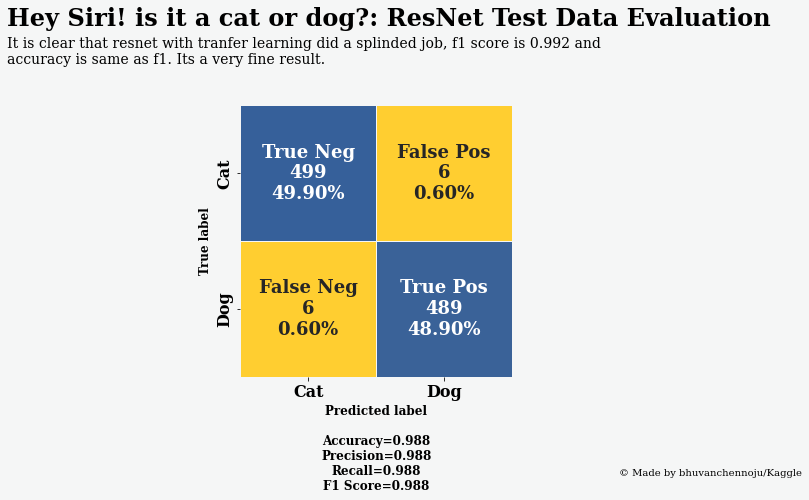

In [32]:
res_cf_matrix = confusion_matrix(test_df['category'],test_df['res_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(res_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories, 
                      title = 'Vanila CNN comfusion matrix')

plt.gcf().text(0,1.1,'ResNet - Avaliação dos dados de teste',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.995,"""Está claro que o modelo resnet fez um ótimo trabalho.""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().show()


In [33]:
#Previsões finais no conjunto de teste
#Preparação de dados de teste final para vanilla e resnet para previsões finais

# gerar um iterador de dataframe para o conjunto de dados de teste

vani_sub_aug_map = ImageDataGenerator()
res_sub_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

vani_sub_data = vani_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)


res_sub_data = res_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)

Found 12500 validated image filenames.
Found 12500 validated image filenames.


In [54]:
#Fazendo previsões finais com as CNNs resnet e vanilla com os dados de teste

vani_pred_sub = vani_model.predict_generator(vani_sub_data)
submission_image_df['vani_pred_sub'] = np.argmax(vani_pred_sub, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())
submission_image_df['vani_pred_sub'] = submission_image_df['vani_pred_sub'].map(labels)


res_pred_sub = resNet_model.predict_generator(res_sub_data)
submission_image_df['res_pred_sub'] = np.argmax(res_pred_sub, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())
submission_image_df['res_pred_sub'] = submission_image_df['res_pred_sub'].map(labels)

print(submission_image_df.head())

    filename vani_pred_sub res_pred_sub
0      1.jpg           cat          dog
1     10.jpg           cat          cat
2    100.jpg           cat          cat
3   1000.jpg           dog          dog
4  10000.jpg           dog          dog


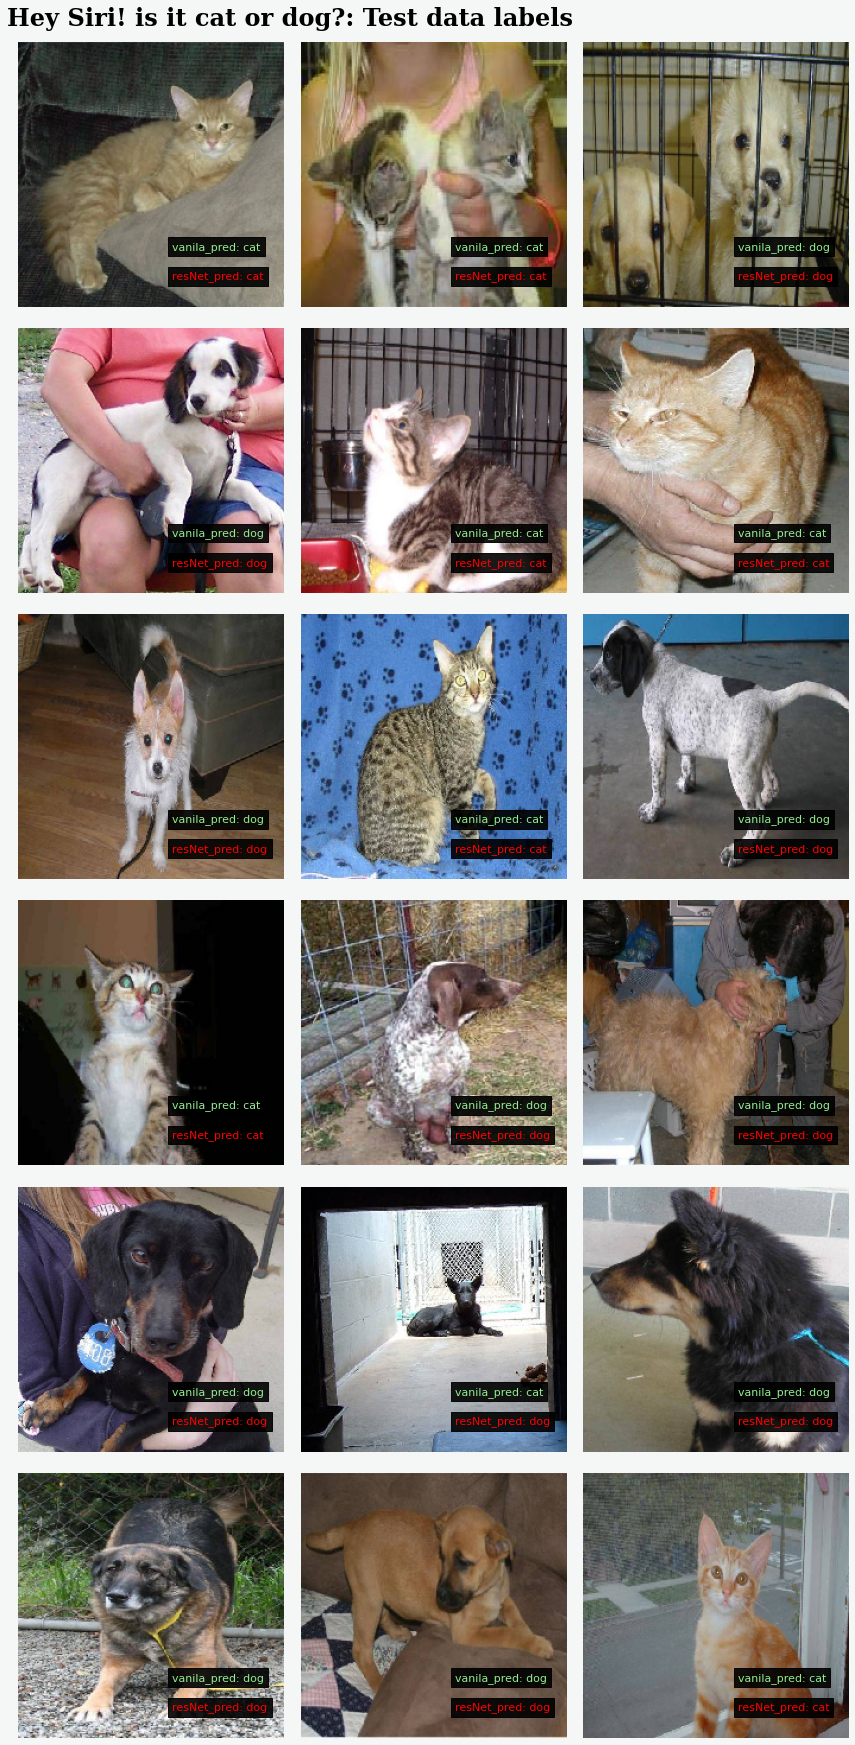

In [38]:
#Vamos ver como nossas previsões são feitas nos dados de teste por ambas as redes

pred_sample = submission_image_df.sample(18)
pred_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('#f5f6f6')

for index, row in pred_sample.iterrows():
    filename = row['filename']
    vani_pred = row['vani_pred_sub']
    res_pred = row['res_pred_sub']
    img = load_img( test_dir + filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(130, 175, 'vanila_pred: {}'.format(vani_pred), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(130, 200, 'resNet_pred: {}'.format(res_pred), color='red',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    #plt.title(filename.split('.')[0])
    del img
plt.tight_layout()
#plt.subplots_adjust( wspace=0, hspace= 1)
fig.text(0,1, 'Rótulos dos dados de teste',{'fontfamily':'serif','size':24,'weight':'bold'})
fig.show()